# import Libraries

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Part1 : Train EfficientnetV2_s over CIFAR100

**Load CIFAR100 Dataset**

In [ ]:
# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-100 dataset
cifar100_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)


# Create PyTorch data loaders 
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Train set size: {len(cifar100_train)}")
print(f"Test set size: {len(cifar100_test)}")


100%|██████████| 169001437/169001437 [00:05<00:00, 30333270.82it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Train set size: 50000
Test set size: 10000


**Load EfficientNetV2-S model**

In [ ]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 84.3MB/s]


In [ ]:
classifier = model.classifier
print(classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


**Training Loop**

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_finetuned.pth')

Epoch 1/9: 100%|██████████| 196/196 [00:45<00:00,  4.27it/s]


Epoch 1/9 | Train Loss: 2.9420 | Train Acc: 28.28% | Val Loss: 1.9080 | Val Acc: 48.33%


Epoch 2/9: 100%|██████████| 196/196 [00:38<00:00,  5.10it/s]


Epoch 2/9 | Train Loss: 1.5890 | Train Acc: 55.56% | Val Loss: 1.5382 | Val Acc: 57.00%


Epoch 3/9: 100%|██████████| 196/196 [00:46<00:00,  4.21it/s]


Epoch 3/9 | Train Loss: 1.1273 | Train Acc: 67.02% | Val Loss: 1.5193 | Val Acc: 58.12%


Epoch 4/9: 100%|██████████| 196/196 [00:38<00:00,  5.06it/s]


Epoch 4/9 | Train Loss: 1.0441 | Train Acc: 69.50% | Val Loss: 1.6985 | Val Acc: 56.20%


Epoch 5/9: 100%|██████████| 196/196 [00:39<00:00,  5.02it/s]


Epoch 5/9 | Train Loss: 0.6760 | Train Acc: 79.30% | Val Loss: 1.3892 | Val Acc: 63.80%


Epoch 6/9: 100%|██████████| 196/196 [00:39<00:00,  4.94it/s]


Epoch 6/9 | Train Loss: 0.3970 | Train Acc: 87.74% | Val Loss: 1.4419 | Val Acc: 64.70%


Epoch 7/9: 100%|██████████| 196/196 [00:38<00:00,  5.11it/s]


Epoch 7/9 | Train Loss: 0.2676 | Train Acc: 91.99% | Val Loss: 1.5167 | Val Acc: 64.77%


Epoch 8/9: 100%|██████████| 196/196 [00:38<00:00,  5.05it/s]


Epoch 8/9 | Train Loss: 0.1786 | Train Acc: 94.86% | Val Loss: 1.6125 | Val Acc: 64.24%


Epoch 9/9: 100%|██████████| 196/196 [00:38<00:00,  5.12it/s]


Epoch 9/9 | Train Loss: 0.1090 | Train Acc: 97.24% | Val Loss: 1.6296 | Val Acc: 64.86%


**Plot Training Result**

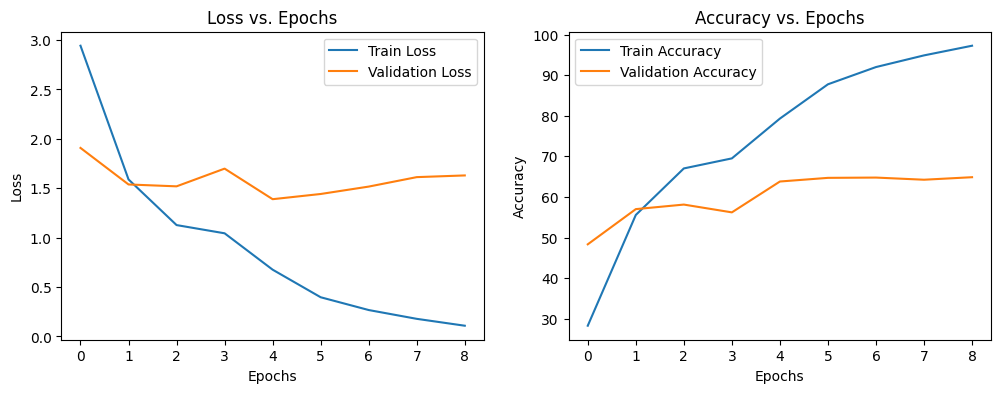

In [ ]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

plt.show()

# Part2 : SI over CIFAR100

In [2]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 59 (delta 26), reused 29 (delta 8), pack-reused 0
Receiving objects: 100% (59/59), 120.32 KiB | 560.00 KiB/s, done.
Resolving deltas: 100% (26/26), done.


**Import Libraries**

In [1]:
import torch
from torchvision import datasets, transforms
import random
import numpy as np

from data_complexity_measures.models.SeprationIndex import Kalhor_SeparationIndex

**Select Ballanced Subset of data**

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Define a function to create a balanced subset of CIFAR-100
def create_balanced_subset(data, labels, subset_size):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    samples_per_class = int(subset_size / num_classes)
    selected_indices = []

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        random_indices = np.random.choice(label_indices, samples_per_class, replace=False)
        selected_indices.extend(random_indices)

    selected_data = data[selected_indices]
    selected_labels = labels[selected_indices]

    return selected_data, selected_labels

In [6]:
# Load the CIFAR-100 dataset and create a balanced subset
transform = transforms.Compose([transforms.ToTensor()])
cifar100_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# Define the subset size 
# different for each metric ( for SI:80% , HSI:60% , for anti SI :60% , for Center SI: 3% only
subset_size = int(0.03 * len(cifar100_dataset)) 

cifar100_data, cifar100_labels = create_balanced_subset(cifar100_dataset.data, np.array(cifar100_dataset.targets), subset_size)

Files already downloaded and verified


**Create an instance of the Kalhor_SeparationIndex class**

In [4]:
# Flatten the data to shape (n_data, n_feature)
cifar100_data = cifar100_data.reshape(subset_size, -1)
# Convert to PyTorch tensor
data_tensor = torch.Tensor(cifar100_data)  
label_tensor = torch.Tensor(cifar100_labels) 
# Make it a 2D tensor
label_tensor = label_tensor.unsqueeze(1)  

# Create Instance of class
si_calculator = Kalhor_SeparationIndex(data_tensor, label_tensor, normalize=True)

data becomes normalized


**Calc SI Data**

In [ ]:
si_data = si_calculator.si_data()

num_ones = torch.sum(si_data == 1).item()
total_elements = si_data.numel()
ratio_ones = num_ones / total_elements

print("First order SI :", ratio_ones)


Ratio of 1s in si_data: 0.161075


**Calc High order SI (order = 2)**

In [ ]:
si_high_order_2_data = si_calculator.high_order_si_data(order=2)
num_ones = torch.sum(si_high_order_2_data == 1).item()
total_elements = si_high_order_2_data.numel()
ratio_ones = num_ones / total_elements

print("High order(2) SI :", ratio_ones)

Ratio of 1s in si__HO2_data: 0.0212


**Calc Soft Order SI**

In [ ]:
si_soft_order_2_data = si_calculator.soft_order_si_data(order=2)

num_ones = torch.sum(si_soft_order_2_data == 1).item()
total_elements = si_soft_order_2_data.numel()
ratio_ones = num_ones / total_elements

print("Soft Order(2) SI :", ratio_ones)

Ratio of 1s in si__HO2_data: 0.0212


**Calc Anti SI**

In [ ]:
anti_si_data = si_calculator.anti_si_data(order=2)

num_ones = torch.sum(anti_si_data == 1).item()
total_elements = anti_si_data.numel()
ratio_ones = num_ones / total_elements

print("Anti SI:", ratio_ones)

Ratio of 1s in si_data: 0.8664


**Calc Center SI**

In [7]:
center_si_data = si_calculator.center_si_data()

num_ones = torch.sum(center_si_data == 1).item()
total_elements = center_si_data.numel()
ratio_ones = num_ones / total_elements

print("Center SI:", ratio_ones)

Center SI: 0.488


# Part3 : SI over Latent Efficient net

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 59 (delta 26), reused 29 (delta 8), pack-reused 0
Receiving objects: 100% (59/59), 120.32 KiB | 1.67 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [8]:
# download Pretrained Model
!gdown 1yWb1OXm7LslxkRx3zHyen-PBZ12-W2sA

Downloading...
From (uriginal): https://drive.google.com/uc?id=1yWb1OXm7LslxkRx3zHyen-PBZ12-W2sA
From (redirected): https://drive.google.com/uc?id=1yWb1OXm7LslxkRx3zHyen-PBZ12-W2sA&confirm=t&uuid=a6a3a226-126b-4cac-9390-c704feb74985
To: /media/arh/HDD/HDD_files/UT/ADDNNL/HW1/Q1/efficientnetv2_s_cifar100_finetuned.pth
100%|██████████████████████████████████████| 82.1M/82.1M [00:23<00:00, 3.50MB/s]


**Import Libraries**

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Subset, DataLoader
import numpy as np
from torch.cuda.amp import autocast, GradScaler

from data_complexity_measures.models.SeprationIndex import Kalhor_SeparationIndex

**Load Model and Get Feature Latent**

In [2]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)


transform = transforms.Compose([
    transforms.Resize(300),  
    transforms.CenterCrop(260),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your pre-trained model weights
model.load_state_dict(torch.load('efficientnetv2_s_cifar100_finetuned.pth'))
model.eval()  # Set the model to evaluation mode
model.cuda()
print("Model Loaded")

Model Loaded


In [3]:
transform = transforms.Compose([transforms.ToTensor()])

# Load the CIFAR-100 dataset
cifar100_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)

# 80% for SI , 0.03 % for center SI and 30% for other Metrics 
subset_size = int(0.03 * len(cifar100_dataset))

# Create a random subset of 20% of the dataset
subset_indices = torch.randperm(len(cifar100_dataset))[:subset_size]
subset_dataset = Subset(cifar100_dataset, subset_indices)

# Define DataLoader for the subset
batch_size = 64
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [4]:
features = []
labels = []


with torch.no_grad():
    for inputs, targets  in tqdm(dataloader):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')
        # Forward pass through the model.features and model.avgpool
        features_batch = model.features(inputs)
        features_batch = model.avgpool(features_batch)
        features.append(features_batch)
        labels.append(targets)

        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()

100%|███████████████████████████████████████████| 24/24 [00:01<00:00, 22.28it/s]


In [5]:
# Stack and reshape the extracted features
features = torch.cat(features)
features = features.view(features.size(0), -1)
labels = torch.cat(labels)

In [6]:
labels = labels.unsqueeze(1)

**Instance Class SI**

In [7]:
instance_disturbance = Kalhor_SeparationIndex(features, labels, normalize=True)

data becomes normalized


In [15]:
# Calc SI
si_data = instance_disturbance.si_data()

num_ones = torch.sum(si_data == 1).item()
total_elements = si_data.numel()
ratio_ones = num_ones / total_elements

print("First order SI on Latent :", ratio_ones)

First order SI on Latent : 0.6441


In [16]:
# Calc SI order 2 on Latent :
si_high_order_2_data = instance_disturbance.high_order_si_data(order=2)
num_ones = torch.sum(si_high_order_2_data == 1).item()
total_elements = si_high_order_2_data.numel()
ratio_ones = num_ones / total_elements

print("High order(2) SI on latent :", ratio_ones)

High order(2) SI on latent : 0.5055


In [17]:
# Calc Soft Order SI on Latent :
si_soft_order_2_data = instance_disturbance.soft_order_si_data(order=2)

num_ones = torch.sum(si_soft_order_2_data == 1).item()
total_elements = si_soft_order_2_data.numel()
ratio_ones = num_ones / total_elements

print("Soft Order(2) SI on Latent :", ratio_ones)

Soft Order(2) SI on Latent : 0.5055


In [18]:
# Calc Anti SI on latent :
anti_si_data = instance_disturbance.anti_si_data(order=2)

num_ones = torch.sum(anti_si_data == 1).item()
total_elements = anti_si_data.numel()
ratio_ones = num_ones / total_elements

print("Anti SI on Latent :", ratio_ones)

Anti SI on Latent : 0.2528


In [8]:
# Center SI on Latent
center_si_data = instance_disturbance.center_si_data()

num_ones = torch.sum(center_si_data == 1).item()
total_elements = center_si_data.numel()
ratio_ones = num_ones / total_elements

print("Center SI on latent:", ratio_ones)

Center SI on latent: 0.85


# Part 4 : Calc Cross SI

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Define a function to create a balanced subset of CIFAR-100
def create_balanced_subset(data, labels, subset_size):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    samples_per_class = int(subset_size / num_classes)
    selected_indices = []

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        random_indices = np.random.choice(label_indices, samples_per_class, replace=False)
        selected_indices.extend(random_indices)

    selected_data = data[selected_indices]
    selected_labels = labels[selected_indices]

    return selected_data, selected_labels

In [5]:
# Load the CIFAR-100 training dataset and create a balanced subset
transform = transforms.Compose([transforms.ToTensor()])
cifar100_train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# Define the subset size (20% of the entire dataset)
subset_size = int(0.2 * len(cifar100_train_dataset))

cifar100_train_data, cifar100_train_labels = create_balanced_subset(cifar100_train_dataset.data, np.array(cifar100_train_dataset.targets), subset_size)

# Flatten the training data to shape (n_data, n_feature)
cifar100_train_data = cifar100_train_data.reshape(subset_size, -1)

# Load the CIFAR-100 test dataset and create a balanced subset
cifar100_test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create a balanced subset for the test data with the same subset size
cifar100_test_data, cifar100_test_labels = create_balanced_subset(cifar100_test_dataset.data, np.array(cifar100_test_dataset.targets), subset_size)

# Flatten the test data to shape (n_data, n_feature)
cifar100_test_data = cifar100_test_data.reshape(subset_size, -1)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Create instances of the Kalhor_SeparationIndex class for both training and test data
train_data_tensor = torch.Tensor(cifar100_train_data)
train_label_tensor = torch.Tensor(cifar100_train_labels).unsqueeze(1)
test_data_tensor = torch.Tensor(cifar100_test_data)
test_label_tensor = torch.Tensor(cifar100_test_labels).unsqueeze(1)

In [7]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)


data becomes normalized
data becomes normalized


In [8]:
# Calculate cross_si_data for the test dataset
cross_si_data = test_si_calculator.cross_si_data(train_data_tensor, train_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)


Cross SI: 0.1106


# Part 5 :  SMI

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [ ]:
import torch
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt

from data_complexity_measures.models.SmoothnessIndex import Kalhor_SmoothnessIndex

In [ ]:
# Load the diabetes dataset
diabetes = load_diabetes()

# Split the data into features (X) and target (y)
X = diabetes.data
y = diabetes.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert NumPy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader 
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
instant = Kalhor_SmoothnessIndex(X_train, y_train)
print('===== SmI========')

===== SmI========


In [ ]:
smi = instant.smi_linear()
print('Linear Smoothness Index is: ', smi.detach().cpu().numpy())
gama = 1
smi = instant.smi_exp(gama)
print('Exponential Smoothness Index is: ', smi.detach().cpu().numpy())

Linear Smoothness Index is:  0.7286107
Exponential Smoothness Index is:  0.56403697


In [ ]:
order = 2
print('=====high order SmI========', 'order=', order)
smi = instant.high_order_smi_linear(order)
print('High Smoothness Index with order', order, ' is:', smi.detach().cpu().numpy())
gama = 1
smi = instant.high_order_smi_exp(order, gama)
print('High Smoothness exp Index with order', order, ' is:', smi.detach().cpu().numpy())

# ================== Anti SmI
order = 1
print('=====Anti SmI========', 'order=', order)
smi = instant.anti_smi_linear(order)
print('Anti Smoothness Index with order', order, ' is:', smi.detach().cpu().numpy())
gama = 1
smi = instant.anti_smi_exp(order, gama)
print('Anti Smoothness exp Index with order', order, ' is:', smi.detach().cpu().numpy())

# ================== soft SmI

order = 2
print('=====soft SmI========', 'order=', order)
smi = instant.soft_order_smi_linear(order)
print('Soft linear Smoothness Index with order', order, ' is:', smi.detach().cpu().numpy())
smi = instant.soft_order_smi_exp(order, gama)
print('Soft Smoothness exp Index with order', order, ' is:', smi.detach().cpu().numpy())
# ================== cross SmI
print('=====cross SmI========')
cr_smi = instant.cross_smi_linear(X_test, y_test)
print('Cross Smootheness Index is: ', cr_smi.detach().cpu().numpy())

# ================== local SmI
print('=====Local SmI========')
n_neighb=25
l_smi, ancher, postitive, negative = instant.triplet_local_smi(n_neighb)
print('Local Smootheness Index is: ', l_smi.detach().cpu().numpy())

# ================== global SmI
print('=====global SmI========')
g_smi, ancher, postitive, negative = instant.triplet_global_smi()
print('Global Smootheness Index is: ', g_smi.detach().cpu().numpy())


=====high order SmI======== order= 2
High Smoothness Index with order 2  is: 0.60883486
High Smoothness exp Index with order 2  is: 0.42122817
=====Anti SmI======== order= 1
Anti Smoothness Index with order 1  is: 0.27138925
Anti Smoothness exp Index with order 1  is: 0.43596306
=====soft SmI======== order= 2
Soft linear Smoothness Index with order 2  is: 0.71688646
Soft Smoothness exp Index with order 2  is: 0.55304766
=====cross SmI========
Cross Smootheness Index is:  0.7635338
=====Local SmI========
Local Smootheness Index is:  0.48441926
=====global SmI========
Global Smootheness Index is:  0.59490085


In [ ]:
# ================== signle_input_smi_linear
print('=====signle_input_smi_linear========')
signle_input_smi_linear = instant.signle_input_smi_linear()
print('the smi score of each input is: ', signle_input_smi_linear.detach().cpu().numpy())

# ================== forward_ranking_smi
print('=====forward_ranking_smi========')

smi_ranked_inputs, ranked_inputs = instant.forward_input_ranking_smi_linear()
print('Ranked  inputs form most important to least important  are: ', ranked_inputs)
print('smi for involving Inputs are: ', smi_ranked_inputs.detach().cpu().numpy())

=====signle_input_smi_linear========
the smi score of each input is:  [0.6182637  0.57505035 0.6725336  0.6519855  0.6438811  0.62310547
 0.66571856 0.67375255 0.6847556  0.67638546]
=====forward_ranking_smi========
Ranked  inputs form most important to least important  are:  tensor([[8., 2., 5., 0., 7., 4., 1., 6., 9., 3.]])
smi for involving Inputs are:  [[0.6847557 ]
 [0.71575105]
 [0.7333702 ]
 [0.7302797 ]
 [0.7315917 ]
 [0.7447439 ]
 [0.7436048 ]
 [0.742936  ]
 [0.7356565 ]
 [0.7286107 ]]


=====forward_input_ranking_by_smi========
Ranked features are:  tensor([[8., 2., 5., 0., 7., 4., 1., 6., 9., 3.]])
smi for the best chosen Inputs are:  [[0.6847557  0.71575105 0.7333702  0.7302797  0.7315917  0.7447439
  0.7436048  0.742936   0.7356565  0.7286107 ]]
=====ranked_features_best========
Sepration Index for input_best_smi is:  0.7447439
the best feachers are:  tensor([[8, 2, 5, 0, 7, 4]])


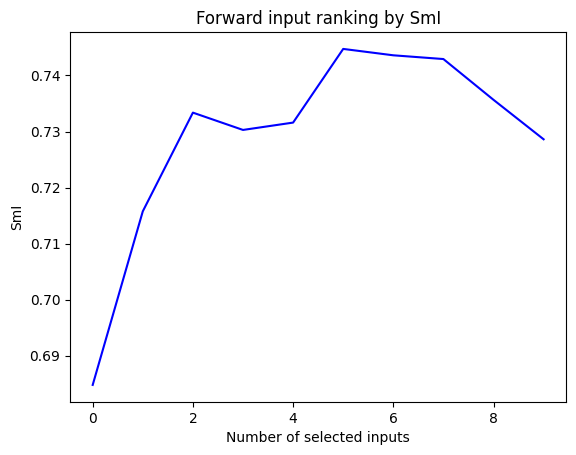

In [ ]:
# ================== forward_selection_smi

print('=====forward_input_ranking_by_smi========')

instance_disturbance = Kalhor_SmoothnessIndex(X_train, y_train)

smi_ranked_inputs, ranked_inputs = instant.forward_input_ranking_smi_linear()

plt.plot(smi_ranked_inputs.cpu().detach().numpy(), 'b')
plt.xlabel("Number of selected inputs")
plt.ylabel("SmI")
plt.title("Forward input ranking by SmI")
smi_ranked_inputs = torch.transpose(smi_ranked_inputs, 0, 1)

print('Ranked features are: ', ranked_inputs)
print('smi for the best chosen Inputs are: ', smi_ranked_inputs.detach().cpu().numpy())
# (9)================== ranked_features_best

print('=====ranked_features_best========')
input_best_smi, ranked_inputs_best = instant.get_best_inputs_forward_smi_linear()

instance_best = Kalhor_SmoothnessIndex(input_best_smi, y_train)

print('Sepration Index for input_best_smi is: ', instance_best.smi_linear().detach().cpu().numpy())
print('the best feachers are: ', ranked_inputs_best.t())

# Part 6 : LDI

In [1]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

fatal: destination path 'data_complexity_measures' already exists and is not an empty directory.


In [14]:
import torch
from torchvision import datasets, transforms
import random
import numpy as np

# from data_complexity_measures.relative_density.mmt_3clustering import Kalhor_Clustering
from data_complexity_measures.relative_density.mmt_8data_domain_scoring import module_data_domain_scoring_unsupervised

In [15]:
# Set the random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Define a function to create a balanced subset of CIFAR-100
def create_balanced_subset(data, labels, subset_size):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    samples_per_class = int(subset_size / num_classes)
    selected_indices = []

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        random_indices = np.random.choice(label_indices, samples_per_class, replace=False)
        selected_indices.extend(random_indices)

    selected_data = data[selected_indices]
    selected_labels = labels[selected_indices]

    return selected_data, selected_labels

In [16]:
# Load the CIFAR-100 training dataset and create a balanced subset
transform = transforms.Compose([transforms.ToTensor()])
cifar100_train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# Define the subset size (10% of the entire dataset)
subset_size = int(0.1 * len(cifar100_train_dataset))

cifar100_train_data, cifar100_train_labels = create_balanced_subset(cifar100_train_dataset.data, np.array(cifar100_train_dataset.targets), subset_size)

# Flatten the training data to shape (n_data, n_feature)
cifar100_train_data = cifar100_train_data.reshape(subset_size, -1)

# Load the CIFAR-100 test dataset and create a balanced subset
cifar100_test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create a balanced subset for the test data with the same subset size
cifar100_test_data, cifar100_test_labels = create_balanced_subset(cifar100_test_dataset.data, np.array(cifar100_test_dataset.targets), subset_size)

# Flatten the test data to shape (n_data, n_feature)
cifar100_test_data = cifar100_test_data.reshape(subset_size, -1)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
train_data_tensor = torch.Tensor(cifar100_train_data)
test_data_tensor = torch.Tensor(cifar100_test_data)

data torch.Size([5000, 3072])
n_max_clusters 100
the predicted number of clusters is: 2
Self Score Index is:  0.32775265
Cross Score Index is:  0.32741174


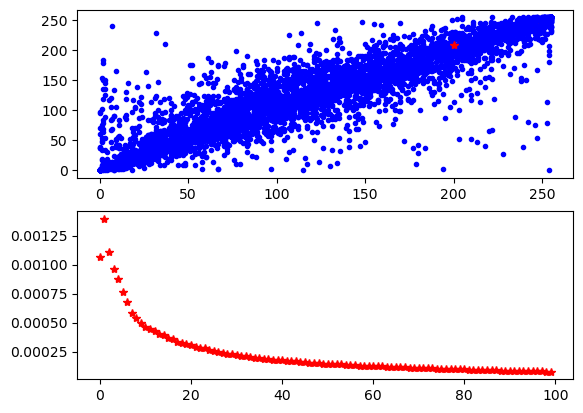

In [18]:
rl , cross = module_data_domain_scoring_unsupervised(train_data_tensor , test_data_tensor)

In [19]:
print("relative Score :" , rl ) 
print("Cross relative Score : " , cross )

relative Score : tensor(0.3278)
Cross relative Score :  tensor(0.3274)
